# Using the SceneWalk Model

In [1]:
import os
import shutil
import sys
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm as normal, truncnorm as truncated_normal
import seaborn as sns

First of all- get data. This will depend on your config file. Mine has the following options.

In [2]:
from scenewalk.utils import loadData
loadData.get_set_names()

spst_all
spst_training
spst_test
corpus_test
corpus_training


In [3]:
dataDict = loadData.load_data("spst_all")
x_dat, y_dat, dur_dat, im_dat, densities_dat, d_range = loadData.dataDict2vars(dataDict)

This data is in the format: subj[Trials[Fixations[]]]

## Scenewalk Model
Here you define the setup of the model.The model object can 

In [4]:
from scenewalk.scenewalk_model_object import scenewalk as scenewalk_model

The model takes the settings:

- how is the inhibition combined (subtractive or divisive)
- how is the attention map initialized (zero or cb)
- is there a post-saccadic attention shift? (on or off)
- is there a pre-saccadic attention shift? (on or off)
- is there an occulomotor potential? (on, off)
- is there slower decay on the previous fixation? (on or off)

It also takes the range of the data. All data for fixations must be provided in degrees. All duration information in seconds (NOT ms).

Lastly it takes a dictionary of other settings for the model, relating to how parameters are passed in and represented in the model. In this case we are estimating log zeta and coupling the two omega parameters by a divisive parameter instead of estimating them separately.

The configuration below is the original SceneWalk model without attention shifts

In [5]:
sw = scenewalk_model("subtractive", "zero", "off", "off", "off", {'x': d_range[0], 'y': d_range[1]}, {"logged_z":True, "coupled_oms":True})

sw.whoami()

'I am a subtractive scenewalk model, initialized with zero activation, in 2 exponents mode, with om_i as a fraction, with logged z'

It will tell you which parameters it needs and the order if you're passing them in as a list:

In [6]:
sw.get_param_list_order()

['omegaAttention',
 'omfrac',
 'sigmaAttention',
 'sigmaInhib',
 'gamma',
 'lamb',
 'inhibStrength',
 'zeta']

You can pass them in as a list **in that order(!)** or as a dictionary with those keys

In [7]:
sw.update_params([1,2,3,4,5,6,7,1])
sw.get_params()

OrderedDict([('omegaAttention', 1),
             ('omegaInhib', 0.5),
             ('sigmaAttention', 3),
             ('sigmaInhib', 4),
             ('gamma', 5),
             ('lamb', 6),
             ('inhibStrength', 7),
             ('zeta', 10)])

The Model is defined within specific bounds. More on this elsewhere, but for roughly

- **omegaAttention** float64.eps : 100000
- **omegaInhib** float64.eps : 100000
- **sigmaAttention** float64.eps : 100000
- **sigmaInhib** float64.eps : 100000
- **lamb** float64.eps : 15
- **gamma** float64.eps : 15
- **inhibStrength** float64.eps : 100000
- **zeta** float64.eps : 1

etc.


In [8]:
# config like what the data suggest
param_dict = OrderedDict({
    "omegaAttention": 18.5,
    "omfrac": 10,
    "sigmaAttention": 6,
    "sigmaInhib": 12,
    "gamma" : 8,
    "lamb" : 0.6,
    "inhibStrength" :0.7,
    "zeta" : -2,
})

In [9]:
sw.update_params(param_dict)
#print(sw.get_params())
print("have we provided all relevant parameters?:", sw.check_params_for_config())
print("are the parameters within the defined bounds?:", sw.check_params_in_bounds())


have we provided all relevant parameters?: True
are the parameters within the defined bounds?: True


Now we have set up our model object. It has 2 main interface functions:

1. get_scanpath_likelihood: gives the likelihood of a scanpath given an image
2. simulate_scanpath: simulates a scanpath on the image

In [10]:
subj = 1
trial = 1
image = im_dat[subj][trial][0]
ll = sw.get_scanpath_likelihood(x_dat[subj][trial],
                                y_dat[subj][trial],
                                dur_dat[subj][trial],
                                densities_dat[image-1])
print("this scan paths sum ll, given the model and the parameters is:", ll)

this scan paths sum ll, given the model and the parameters is: -222.76976052646520093


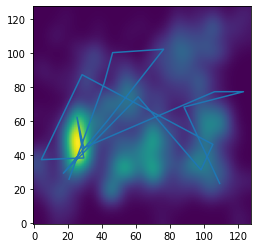

In [12]:
subj = 1
trial = 1
image = im_dat[subj][trial][0]
x_path, y_path = sw.simulate_scanpath(dur_dat[subj][trial],
                                      densities_dat[image-1],
                                      [5,5])

from scenewalk.plotting import sw_plot
sw_plot.plot_path_on_map(densities_dat[image-1], x_path,y_path, sw)
